# Reflexion

https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/reflexion/reflexion.ipynb

[Reflexion](https://arxiv.org/abs/2303.11366) by Shinn, et. al., is an architecture designed to learn through verbal feedback and self-reflection. The agent explicitly critiques its responses for tasks to generate a higher quality final response, at the expense of longer execution time.

The paper outlines 3 main components:

1. Actor (agent) with self-reflection
2. External evaluator (task-specific, e.g. code compilation steps)
3. Episodic memory that stores the reflections from (1).

![reflexion](reflexion.png)
In their code, the last two components are very task-specific, so in this notebook, you will build the _actor_ in LangGraph.

## Setup

In [25]:
from dotenv import load_dotenv
load_dotenv()
MAX_CRITIQUES = 2
MAX_ITERATIONS = 4

In [26]:
from langchain_openai import ChatOpenAI
from langchain_community.chat_models import ChatZhipuAI
import os

llama_model = ChatOpenAI(
    model="llama3.3",
    base_url="http://localhost:11434/v1",
    temperature=0
)

zhipu_model = ChatZhipuAI(
    model="GLM-4-Plus",
    temperature=0
)

kimi_model = ChatOpenAI(
    model="moonshot-v1-8k",
    api_key=os.environ["MOONSHOT_API_KEY"],
    base_url="https://api.moonshot.cn/v1",
)

llms = [zhipu_model, kimi_model, llama_model]

## Actor (with reflection)

The main component of Reflexion is the "actor", which is an agent that reflects on its response and re-executes to improve based on self-critique. It's main sub-components include:
1. Tools/tool execution
2. Initial responder: generate an initial response (and self-reflection)
3. Revisor: re-respond (and reflec) based on previous reflections

We'll first define the tool execution context.

#### 1 Construct tools

In [27]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper

# https://api.tavily.com
tavily = TavilySearchResults(
    api_wrapper=TavilySearchAPIWrapper(), max_results=5)

# https://duckduckgo.com/
duck_duck_go = DuckDuckGoSearchResults(
    api_wrapper=DuckDuckGoSearchAPIWrapper(), max_results=5)

search_tools = [tavily, tavily, duck_duck_go]

#### 2 Initial responder

<div class="admonition note">
    <p class="admonition-title">Using Pydantic with LangChain</p>
    <p>
        This notebook uses Pydantic v2 <code>BaseModel</code>, which requires <code>langchain-core >= 0.3</code>. Using <code>langchain-core < 0.3</code> will result in errors due to mixing of Pydantic v1 and v2 <code>BaseModels</code>.
    </p>
</div>

In [28]:
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import ValidationError
from pydantic import BaseModel, Field
import json


class Reflection(BaseModel):
    missing: str = Field(description="Critique of what is missing.")
    superfluous: str = Field(description="Critique of what is superfluous")


class AnswerQuestion(BaseModel):
    """Answer the question. Provide an answer, reflection, and then follow up with search queries to improve the answer."""

    answer: str = Field(
        description="~250 word detailed answer to the question.")
    reflection: Reflection = Field(
        description="Your reflection on the initial answer.")
    search_queries: list[str] = Field(
        description="1-3 search queries for researching improvements to address the critique of your current answer."
    )


class ResponderWithRetries:
    def __init__(self, runnable, validator):
        self.runnable = runnable
        self.validator = validator

    def respond(self, state: list):
        response = []
        for attempt in range(MAX_CRITIQUES):
            response = self.runnable.invoke(
                {"messages": state["messages"]}, {
                    "tags": [f"attempt:{attempt}"]}
            )
            try:
                self.validator.invoke(response)
                return {"messages": response}
            except ValidationError as e:
                schema_json = json.dumps(self.validator.model_json_schema())
                state["messages"] += [
                    response,
                    ToolMessage(
                        content=f"{
                            repr(e)}\n\nPay close attention to the function schema.\n\n"
                        + schema_json
                        + " Respond by fixing all validation errors.",
                        tool_call_id=response.tool_calls[0]["id"],
                    ),
                ]
        return {"messages": response}

In [29]:
import datetime

actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are expert researcher.
Current time: {time}

1. {first_instruction}
2. Reflect and critique your answer. Be severe to maximize improvement.
3. Recommend search queries to research information and improve your answer.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
        (
            "user",
            "\n\n<system>Reflect on the user's original question and the"
            " actions taken thus far. Respond using the {function_name} function.</reminder>",
        ),
    ]
).partial(
    time=lambda: datetime.datetime.now().isoformat(),
)
initial_answer_chain = actor_prompt_template.partial(
    first_instruction="Provide a detailed ~250 word answer.",
    function_name=AnswerQuestion.__name__,
) | llms[0].bind_tools(tools=[AnswerQuestion])
validator = PydanticToolsParser(tools=[AnswerQuestion])

first_responder = ResponderWithRetries(
    runnable=initial_answer_chain, validator=validator
)

In [30]:
# example_question = "Why is reflection useful in AI?"
# initial = first_responder.respond(
#     {"messages": [HumanMessage(content=example_question)]}
# )

#### 3 Revision

The second part of the actor is a revision step.

In [31]:
revise_instructions = """Revise your previous answer using the new information.
    - You should use the previous critique to add important information to your answer.
        - You MUST include numerical citations in your revised answer to ensure it can be verified.
        - Add a "References" section to the bottom of your answer (which does not count towards the word limit). In form of:
            - [1] https://example.com
            - [2] https://example.com
    - You should use the previous critique to remove superfluous information from your answer and make SURE it is not more than 250 words.
"""

# Extend the initial answer schema to include references.
# Forcing citation in the model encourages grounded responses
class ReviseAnswer(AnswerQuestion):
    """Revise your original answer to your question. Provide an answer, reflection,

    cite your reflection with references, and finally
    add search queries to improve the answer."""

    references: list[str] = Field(
        description="Citations motivating your updated answer."
    )


revision_chain = actor_prompt_template.partial(
    first_instruction=revise_instructions,
    function_name=ReviseAnswer.__name__,
) | llms[1].bind_tools(tools=[ReviseAnswer])
revision_validator = PydanticToolsParser(tools=[ReviseAnswer])

revisor = ResponderWithRetries(
    runnable=revision_chain, validator=revision_validator)

In [32]:
# import json

# revised = revisor.respond(
#     {
#         "messages": [
#             HumanMessage(content=example_question),
#             initial["messages"],
#             ToolMessage(
#                 tool_call_id=initial["messages"].tool_calls[0]["id"],
#                 content=json.dumps(
#                     tavily_tool.invoke(
#                         {
#                             "query": initial["messages"].tool_calls[0]["args"][
#                                 "search_queries"
#                             ][0]
#                         }
#                     )
#                 ),
#             ),
#         ]
#     }
# )
# revised["messages"]

## Create Tool Node

Next, create a node to execute the tool calls. While we give the LLMs different schema names (and use those for validation), we want them both to route to the same tool.

In [33]:
from langchain_core.tools import StructuredTool
from langgraph.prebuilt import ToolNode

def run_queries(search_queries: list[str], **kwargs):
    """Run the generated queries."""
    return search_tools[0].batch([{"query": query} for query in search_queries])


def run_queries2(search_queries: list[str], **kwargs):
    """Run the generated queries."""
    return search_tools[1].batch([{"query": query} for query in search_queries])

tool_node = ToolNode(
    [
        StructuredTool.from_function(run_queries, name=AnswerQuestion.__name__),
        StructuredTool.from_function(run_queries2, name=ReviseAnswer.__name__),
    ]
)

## Construct Graph


Now we can wire all our components together.

In [34]:
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict

class State(TypedDict):
    messages: Annotated[list, add_messages]

builder = StateGraph(State)
builder.add_node("draft", first_responder.respond)


builder.add_node("execute_tools", tool_node)
builder.add_node("revise", revisor.respond)
# draft -> execute_tools
builder.add_edge("draft", "execute_tools")
# execute_tools -> revise
builder.add_edge("execute_tools", "revise")

# Define looping logic:
def _get_num_iterations(state: list):
    i = 0
    for m in state[::-1]:
        if m.type not in {"tool", "ai"}:
            break
        i += 1
    return i

def event_loop(state: list):
    # in our case, we'll just stop after N plans
    num_iterations = _get_num_iterations(state["messages"])
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"

# revise -> execute_tools OR end
builder.add_conditional_edges("revise", event_loop, ["execute_tools", END])
builder.add_edge(START, "draft")
graph = builder.compile()

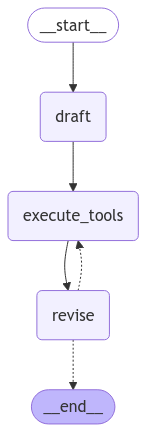

In [35]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [36]:
query = "明年最有发展的国家是？"
events = graph.stream(
    {"messages": [("user", query)]},
    stream_mode="values",
)

for i, step in enumerate(events):
    print(f"Step {i}")
    step["messages"][-1].pretty_print()

Step 0
================================ Human Message =================================

明年最有发展的国家是？
Step 1
================================== Ai Message ==================================
Tool Calls:
  AnswerQuestion (call_-9158280088861264363)
 Call ID: call_-9158280088861264363
  Args:
    answer: 预测明年最有发展的国家涉及多方面因素，包括经济政策、政治稳定性、科技创新、资源储备等。目前，一些国家如中国、印度、美国因其在这些领域的强劲表现而备受关注。中国和印度作为新兴市场，拥有庞大的人口基数和快速发展的经济；美国则凭借其科技创新和成熟的金融市场保持竞争力。然而，具体哪个国家将表现最佳，还需考虑全球经济环境、地缘政治变化等不确定因素。
    reflection: {'missing': '缺乏具体数据和近期全球经济政治趋势分析，未能提供更精确的预测依据。', 'superfluous': '对国家的一般性描述过多，未能聚焦于具体的发展潜力和预测依据。'}
    search_queries: ['2025年全球经济预测', '2025年地缘政治趋势', '2025年科技创新国家排名']
Step 2
================================= Tool Message =================================
Name: AnswerQuestion

[[{"url": "https://www.huxiu.com/article/3616892.html", "content": "IMF 2025年展望：全球经济将如何发展？-虎嗅网 虎嗅APP__虎嗅APP 公众号矩阵__公众号矩阵 我要投稿__我要投稿 资讯 24小时 源流 视频 专题/活动 妙投 虎嗅智库 IMF 2025年展望：全球经济将如何发展？ 培风客©关注 本文来自微信公众号：培风客 （ID：peifengke），作者：Odysseus，原文标题

BadRequestError: Error code: 400 - {'error': {'message': 'Invalid request: Your request exceeded model token limit: 8192', 'type': 'invalid_request_error'}}

## Conclusion

Congrats on building a Reflexion actor! I'll leave you with a few observations to save you some time when choosing which parts of this agent to adapt to your workflow:
1. This agent trades off execution time for quality. It explicitly forces the agent to critique and revise the output over several steps, which usually (not always) increases the response quality but takes much longer to return a final answer
2. The 'reflections' can be paired with additional external feedback (such as validators), to further guide the actor.
3. In the paper, 1 environment (AlfWorld) uses external memory. It does this by storing summaries of the reflections to an external store and using them in subsequent trials/invocations.